# 图像增广

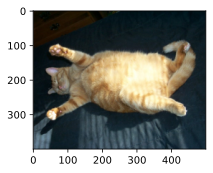

In [1]:
# 在Jupyter Notebook中显示matplotlib图形
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()  # 设置图形大小
img = d2l.Image.open('../img/cat1.jpg')  # 使用d2l库的Image模块打开图像文件
d2l.plt.imshow(img)  # 使用d2l库的plt模块显示图像

In [2]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    """
    在图像上应用数据增强变换并显示结果。

    Parameters:
        img (PIL.Image.Image): 要应用变换的图像。
        aug (torchvision.transforms.Compose): 数据增强变换。
        num_rows (int): 要显示的图像行数。
        num_cols (int): 要显示的图像列数。
        scale (float): 图像显示的尺度。

    Returns:
        None
    """
    # 使用指定的数据增强变换对图像进行变换
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    
    # 使用d2l库的show_images函数显示应用变换后的图像
    d2l.show_images(Y, num_rows, num_cols, scale=scale)


## 翻转和裁剪

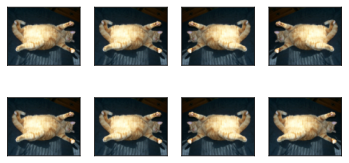

In [3]:
# 随机地对图像进行水平翻转，即左右翻转。
apply(img, torchvision.transforms.RandomHorizontalFlip())

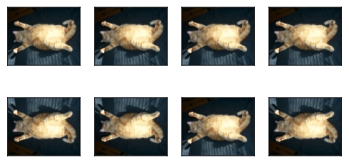

In [4]:
# 随机地对图像进行垂直翻转，即上下翻转。
apply(img, torchvision.transforms.RandomVerticalFlip())

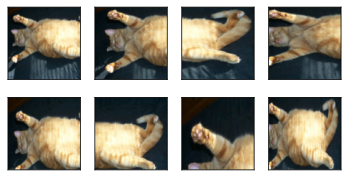

In [5]:
# 随机resize及裁剪增强
shape_aug = torchvision.transforms.RandomResizedCrop(size=(200, 200),   # 裁剪大小                                                
                                                     scale=(0.1, 1),    # 随机缩放范围
                                                     ratio=(0.5, 2))    # 随机长宽比范围
apply(img, shape_aug)

## 改变颜色

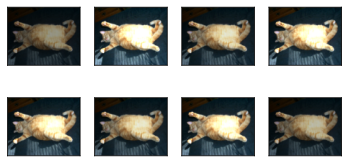

In [6]:
# 随机调整图像亮度,对比度,饱和度等增强数据
apply(img, torchvision.transforms.ColorJitter(brightness=0.5,   # 随机变化亮度,参数0.5表示调整范围是原图亮度的50%
                                              contrast=0,       # 对比度不变
                                              saturation=0,     # 饱和度不变
                                              hue=0))            # 色相不变

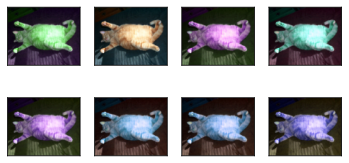

In [16]:
apply(img, torchvision.transforms.ColorJitter(brightness=0,   # 亮度不变
                                              contrast=0,     # 对比度不变
                                              saturation=0,   # 饱和度不变
                                              hue=0.5))        # 色相随机变化 +/- 0.5

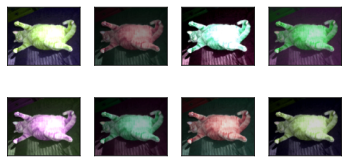

In [17]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5,   # 随机变化亮度 50%
                                               contrast=0.5,     # 随机变化对比度 50%
                                               saturation=0.5,   # 随机变化饱和度 50%
                                               hue=0.5)          # 随机变化色相 -0.5 ~ 0.5

apply(img, color_aug)

## 结合多种图像增广方法

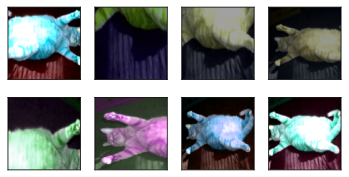

In [18]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

## 使用图像增广进行训练

Files already downloaded and verified


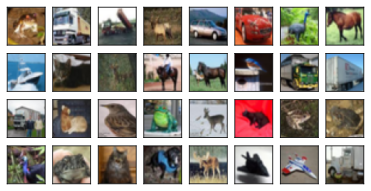

In [22]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [23]:
# 训练数据增强
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), # 随机水平翻转
    torchvision.transforms.ToTensor(),             # 将图片转为Tensor
])

# 测试数据预处理 
test_augs = torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),             # 将图片转为Tensor
])

In [24]:
def load_cifar10(is_train, augs, batch_size):
    """
    加载CIFAR-10数据集,并返回一个数据加载器。

    Parameters:
        is_train (bool): 是否加载训练集(True)或测试集(False)。
        augs (torchvision.transforms.Compose): 数据增强变换。
        batch_size (int): 批量大小。

    Returns:
        torch.utils.data.DataLoader: CIFAR-10数据加载器。
    """
     # 使用torchvision.datasets.CIFAR10加载CIFAR-10数据集，指定根目录、是否训练、预处理变换、是否下载
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train, transform=augs, download=True)
    # 使用torch.utils.data.DataLoader创建数据加载器，指定批量大小、是否打乱、多线程工作数
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

## 多GPU训练

In [25]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """
    在多GPU上进行小批量训练。

    Parameters:
        net (torch.nn.Module): 要训练的神经网络模型。
        X (torch.Tensor or list): 输入数据。
        y (torch.Tensor): 标签数据。
        loss (torch.nn.Module): 损失函数。
        trainer (torch.optim.Optimizer): 优化器。
        devices (list of torch.device): 使用的GPU设备列表。

    Returns:
        torch.Tensor, torch.Tensor: 训练损失总和，训练精度总和。
    """
    # 如果X是一个列表（多个数据张量）
    if isinstance(X, list):
        # 将列表中的数据移到第一个 GPU 上（若有多个 GPU）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])

    # 将网络设置为训练模式并清空梯度
    net.train()
    trainer.zero_grad()

    # 前向传播计算预测值
    pred = net(X)

    # 计算损失并进行反向传播
    l = loss(pred, y)
    l.sum().backward()

    # 更新模型参数
    trainer.step()

    # 计算训练损失总和和训练精度总和
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)

    return train_loss_sum, train_acc_sum


def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    """
    在多GPU上进行模型训练。

    Parameters:
        net (torch.nn.Module): 要训练的神经网络模型。
        train_iter (torch.utils.data.DataLoader): 训练数据加载器。
        test_iter (torch.utils.data.DataLoader): 测试数据加载器。
        loss (torch.nn.Module): 损失函数。
        trainer (torch.optim.Optimizer): 优化器。
        num_epochs (int): 训练的总轮数。
        devices (list of torch.device): 使用的GPU设备列表。

    Returns:
        None
    """
    timer, num_batches = d2l.Timer(), len(train_iter)
    # 创建一个动画图表来可视化训练过程中的损失和准确度
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], 
                            legend=['train loss', 'train acc', 'test acc'])

    # 将网络放入多个 GPU 上并设置为训练模式
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    # 开始迭代训练
    for epoch in range(num_epochs):
        # 用于累积训练损失、训练准确度、实例数和样本数的指标
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            # 在每个 epoch 结束后，使用动画图表进行可视化
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3], None))

        # 在测试集上评估模型精度
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))

    # 打印最终结果和训练速度
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [26]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

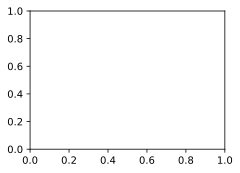

In [27]:
train_with_data_aug(train_augs, test_augs, net)